In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mycolorpy import colorlist as mcp

import xgboost
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")

test_date = "2017-08-05"

# 1) Data Reading and Inspection

- Read and get info from the dataset

In [2]:
#read dataset
bus_df = pd.read_csv("municipality_bus_utilization.csv", encoding="utf-8")
bus_df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


In [3]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


In [4]:
bus_df.describe().T

,count,mean,std,min,25%,50%,75%,max
municipality_id,13070.0,4.500000,2.872391,0.0,2.0,4.5,7.0,9.0
usage,13070.0,876.002984,679.287109,11.0,403.0,692.0,1190.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,697.0,1974.5,2947.0,3893.0


- It looks like timestamp column is string object. We should convert it to datetime object. 

In [5]:
bus_df["timestamp"] = pd.to_datetime(bus_df["timestamp"], dayfirst=False)
bus_df["timestamp"]

0       2017-06-04 07:59:42
1       2017-06-04 07:59:42
2       2017-06-04 07:59:42
3       2017-06-04 07:59:42
4       2017-06-04 07:59:42
                ...        
13065   2017-08-19 16:30:35
13066   2017-08-19 16:30:35
13067   2017-08-19 16:30:35
13068   2017-08-19 16:30:35
13069   2017-08-19 16:30:35
Name: timestamp, Length: 13070, dtype: datetime64[ns]

- We should standardize minutes and seconds to ease feature generation later

In [6]:
#get date, hour and minute information from timestamp
bus_df["date"] =  bus_df["timestamp"].apply(lambda x: x.date())
bus_df["hour"] =  bus_df["timestamp"].apply(lambda x: x.hour)
bus_df["minute"] =  bus_df["timestamp"].apply(lambda x: x.minute)

bus_df

,timestamp,municipality_id,usage,total_capacity,date,hour,minute
0,2017-06-04 07:59:42,9,454,1332,2017-06-04,7,59
1,2017-06-04 07:59:42,8,556,2947,2017-06-04,7,59
2,2017-06-04 07:59:42,4,1090,3893,2017-06-04,7,59
3,2017-06-04 07:59:42,0,204,2813,2017-06-04,7,59
4,2017-06-04 07:59:42,7,718,2019,2017-06-04,7,59
...,...,...,...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697,2017-08-19,16,30
13066,2017-08-19 16:30:35,8,1193,2947,2017-08-19,16,30
13067,2017-08-19 16:30:35,7,1354,2019,2017-08-19,16,30
13068,2017-08-19 16:30:35,6,1680,3113,2017-08-19,16,30


In [7]:
#convert minutes to 00 or 30 depending on its closeness
def convert_time(df):

    if df["minute"] != 0 or df["minute"] != 30:
        if df["minute"] < 15:
            df["minute"] = 0
        elif df["minute"] < 30:
            df["minute"] = 30
        elif df["minute"] < 45:
            df["minute"] = 30
        else:
            df["minute"] = 0
            df["hour"] += 1

    return df

bus_df = bus_df.apply(lambda x: convert_time(x), axis=1)

In [8]:
#
bus_df["timestamp"] = pd.to_datetime(
    bus_df.date.astype(str) + " " + bus_df.hour.astype(str) + ":" + bus_df.minute.astype(str) + ":00"
    )
    
bus_df["timestamp"]

0       2017-06-04 08:00:00
1       2017-06-04 08:00:00
2       2017-06-04 08:00:00
3       2017-06-04 08:00:00
4       2017-06-04 08:00:00
                ...        
13065   2017-08-19 16:30:00
13066   2017-08-19 16:30:00
13067   2017-08-19 16:30:00
13068   2017-08-19 16:30:00
13069   2017-08-19 16:30:00
Name: timestamp, Length: 13070, dtype: datetime64[ns]

In [9]:
#find maximum usage and total capacities for each hour for municipalities
for municipality in set(bus_df["municipality_id"]):
    temp_df = bus_df[bus_df["municipality_id"] == municipality]

    unique_dates = temp_df["date"].unique()

    for unique_date in unique_dates:
        hours = temp_df["hour"].unique()

        for hour in hours:
            hour_rows = temp_df[temp_df["date"] == unique_date].groupby("hour").get_group(hour)
            bus_df.loc[hour_rows.index, "usage"] = hour_rows["usage"].agg(max)    
            bus_df.loc[hour_rows.index, "total_capacity"] = hour_rows["total_capacity"].agg(max)    

In [10]:
#drop minute == 30 rows to use hourly usages
half_hour_ind = bus_df.query("minute == 30").index

bus_df.drop(half_hour_ind, axis=0, inplace=True)
bus_df.drop(columns={"date","minute"}, axis=1, inplace=True)
bus_df.reset_index(inplace=True, drop=True)

bus_df

,timestamp,municipality_id,usage,total_capacity,hour
0,2017-06-04 08:00:00,9,487,1332,8
1,2017-06-04 08:00:00,8,674,2947,8
2,2017-06-04 08:00:00,4,1476,3893,8
3,2017-06-04 08:00:00,0,247,2813,8
4,2017-06-04 08:00:00,7,789,2019,8
...,...,...,...,...,...
6525,2017-08-19 16:00:00,7,1450,2019,16
6526,2017-08-19 16:00:00,2,580,697,16
6527,2017-08-19 16:00:00,3,1330,1930,16
6528,2017-08-19 16:00:00,8,1253,2947,16


In [11]:
#Check null values
bus_df.isna().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
hour               0
dtype: int64

In [12]:
#set timestamp column as index
bus_df.set_index("timestamp", inplace=True)

# 2) Exploratory Data Analysis

- Visualize and explore the data

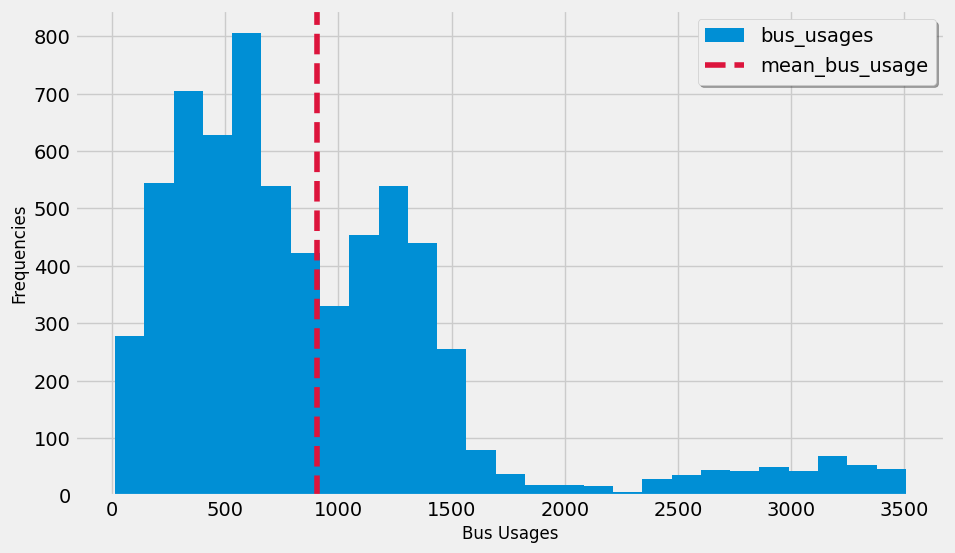

In [13]:
#plot bus usage frequencies
fig, ax = plt.subplots(figsize=(10,6))
bus_df["usage"].hist(bins="scott", ax=ax, label="bus_usages")
ax.axvline(np.mean(bus_df["usage"]), ls="dashed", color="crimson", label="mean_bus_usage")
plt.xlabel("Bus Usages", fontsize=12)
plt.ylabel("Frequencies", fontsize=12)
plt.legend(loc="best", shadow=True, fancybox=True)
plt.grid(True)
plt.show()

In [14]:
#remove first and last 1% of usage values as they may be outliers
q = 0.01
lower_q = np.quantile(bus_df["usage"], q=q)
higher_q = np.quantile(bus_df["usage"], q=1-q)

len_org = len(bus_df)
bus_df = bus_df[(bus_df["usage"] > lower_q) & (bus_df["usage"] < higher_q)]
len_now = len(bus_df)

print("Total of", len_org - len_now, "outliers are removed")

Total of 133 outliers are removed


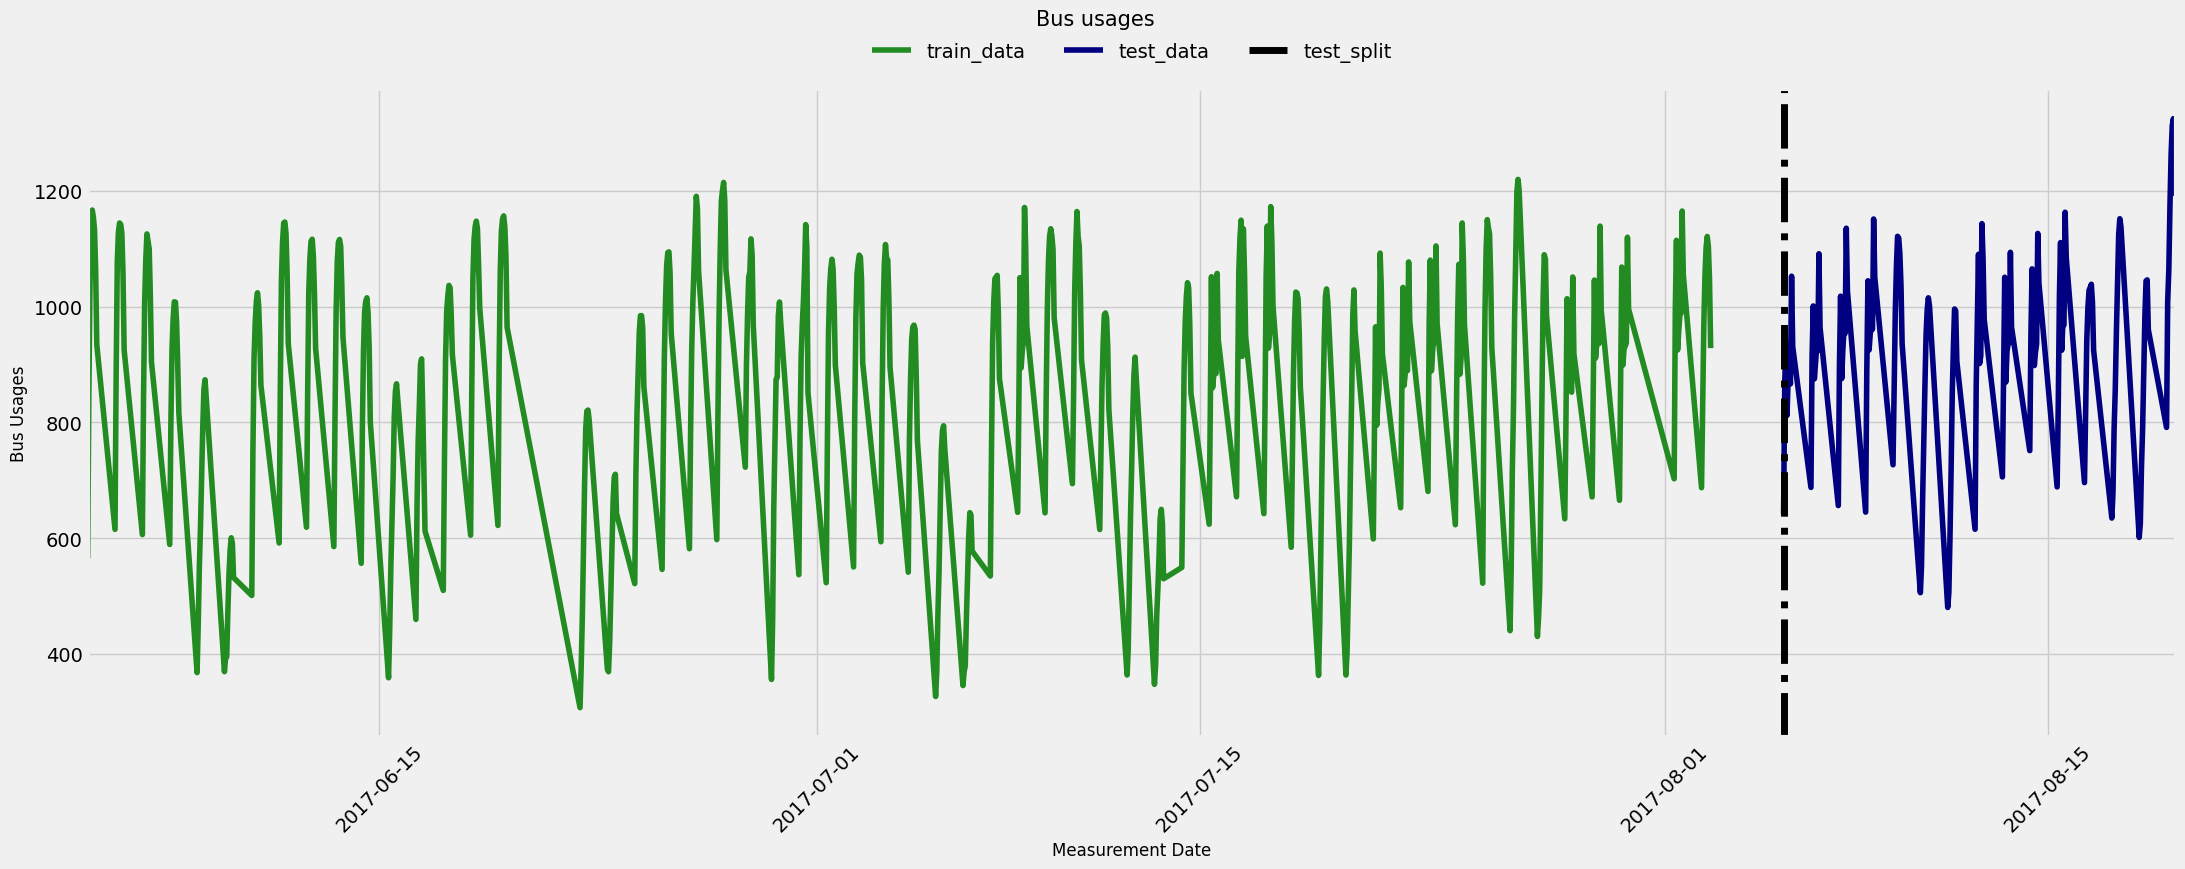

In [15]:
#plot the time series bus usages through entire data by municipalities
train = bus_df.loc[bus_df.index < test_date]
test = bus_df.loc[bus_df.index >= test_date]

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=train, x=train.index, y="usage", errorbar=None, label="train_data", c="forestgreen")
sns.lineplot(data=test, x=test.index, y="usage", errorbar=None, label="test_data", c="navy")
plt.axvline(test.index[0], lw=5, ls="dashdot", color="black", label="test_split") #add a line at test set date

plt.xlim([train.index.min(), test.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False)

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages", fontsize=15)
plt.show()

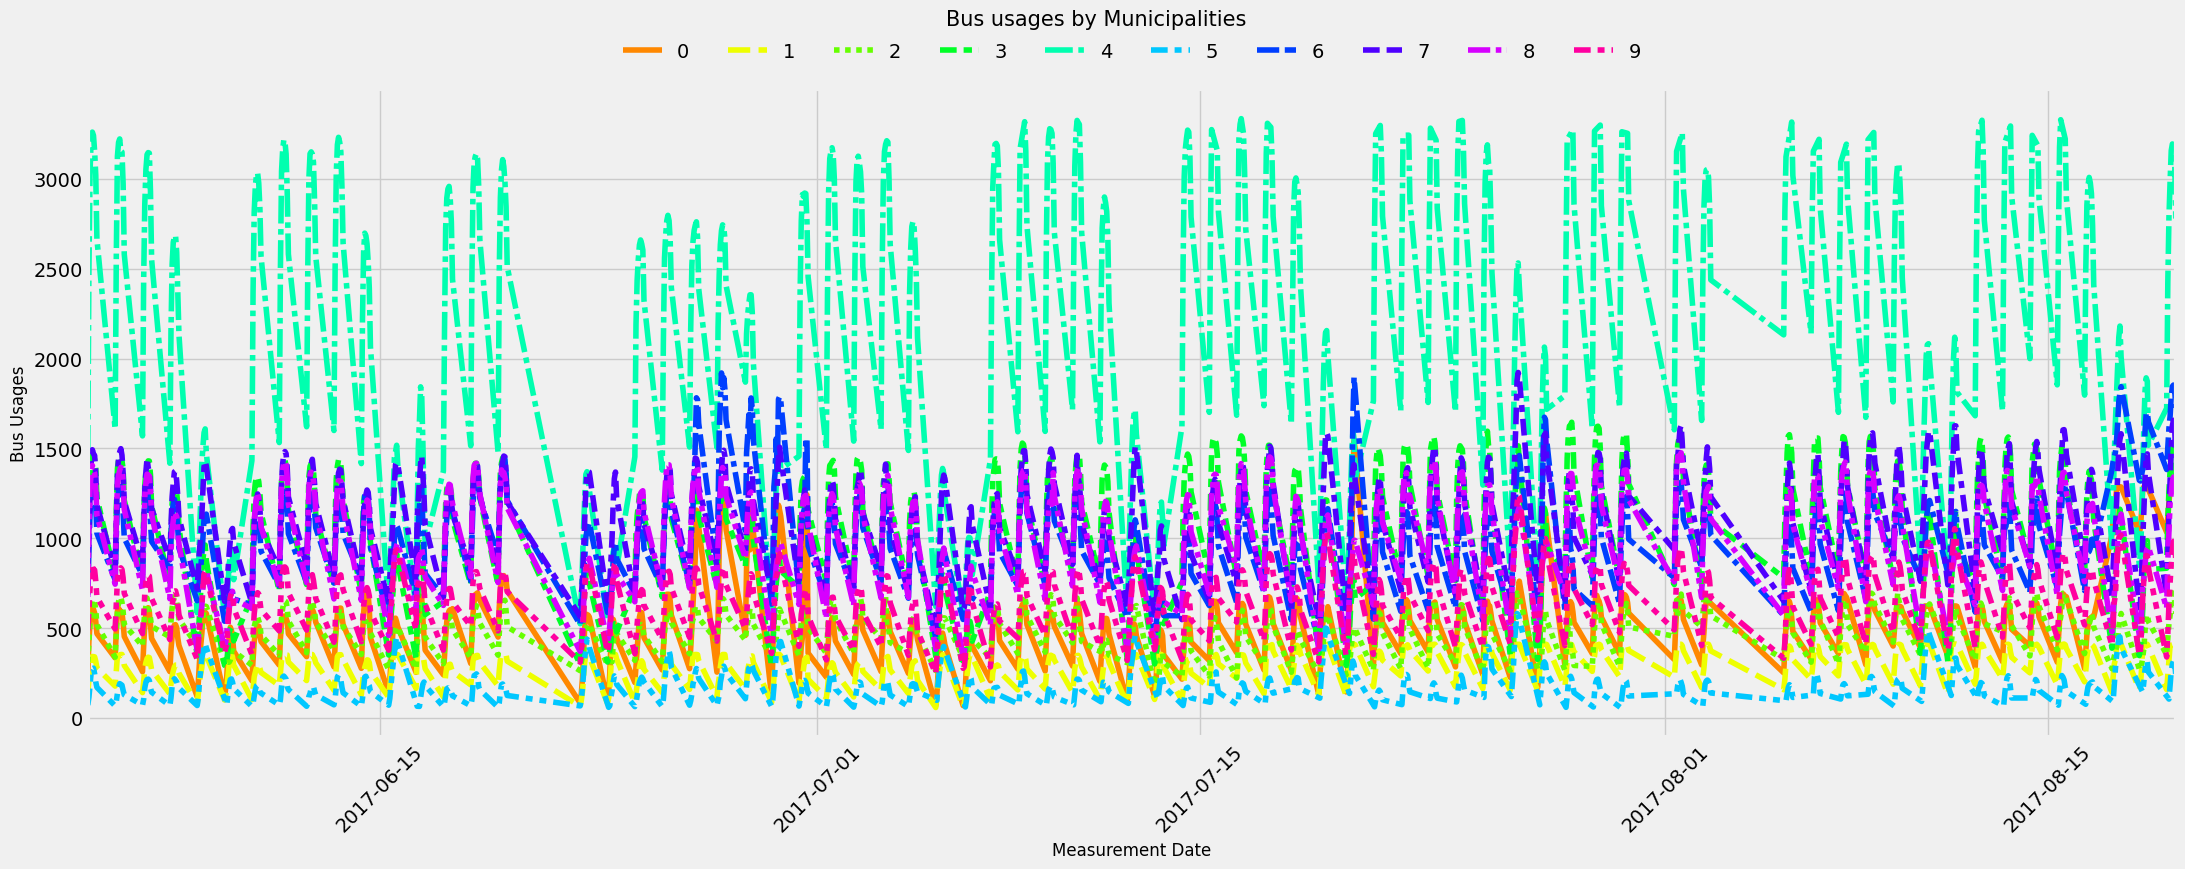

In [16]:
#plot the time series bus usages through entire data by municipalities
pivot_df = pd.pivot_table(data = bus_df, index=bus_df.index, values="usage", columns="municipality_id")

fig, ax = plt.subplots(figsize=(24,8))

sns.lineplot(data=pivot_df, palette="hsv")

plt.xlim([pivot_df.index.min(), pivot_df.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncol=len(pivot_df.columns))

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages by Municipalities", fontsize=15)
plt.show()

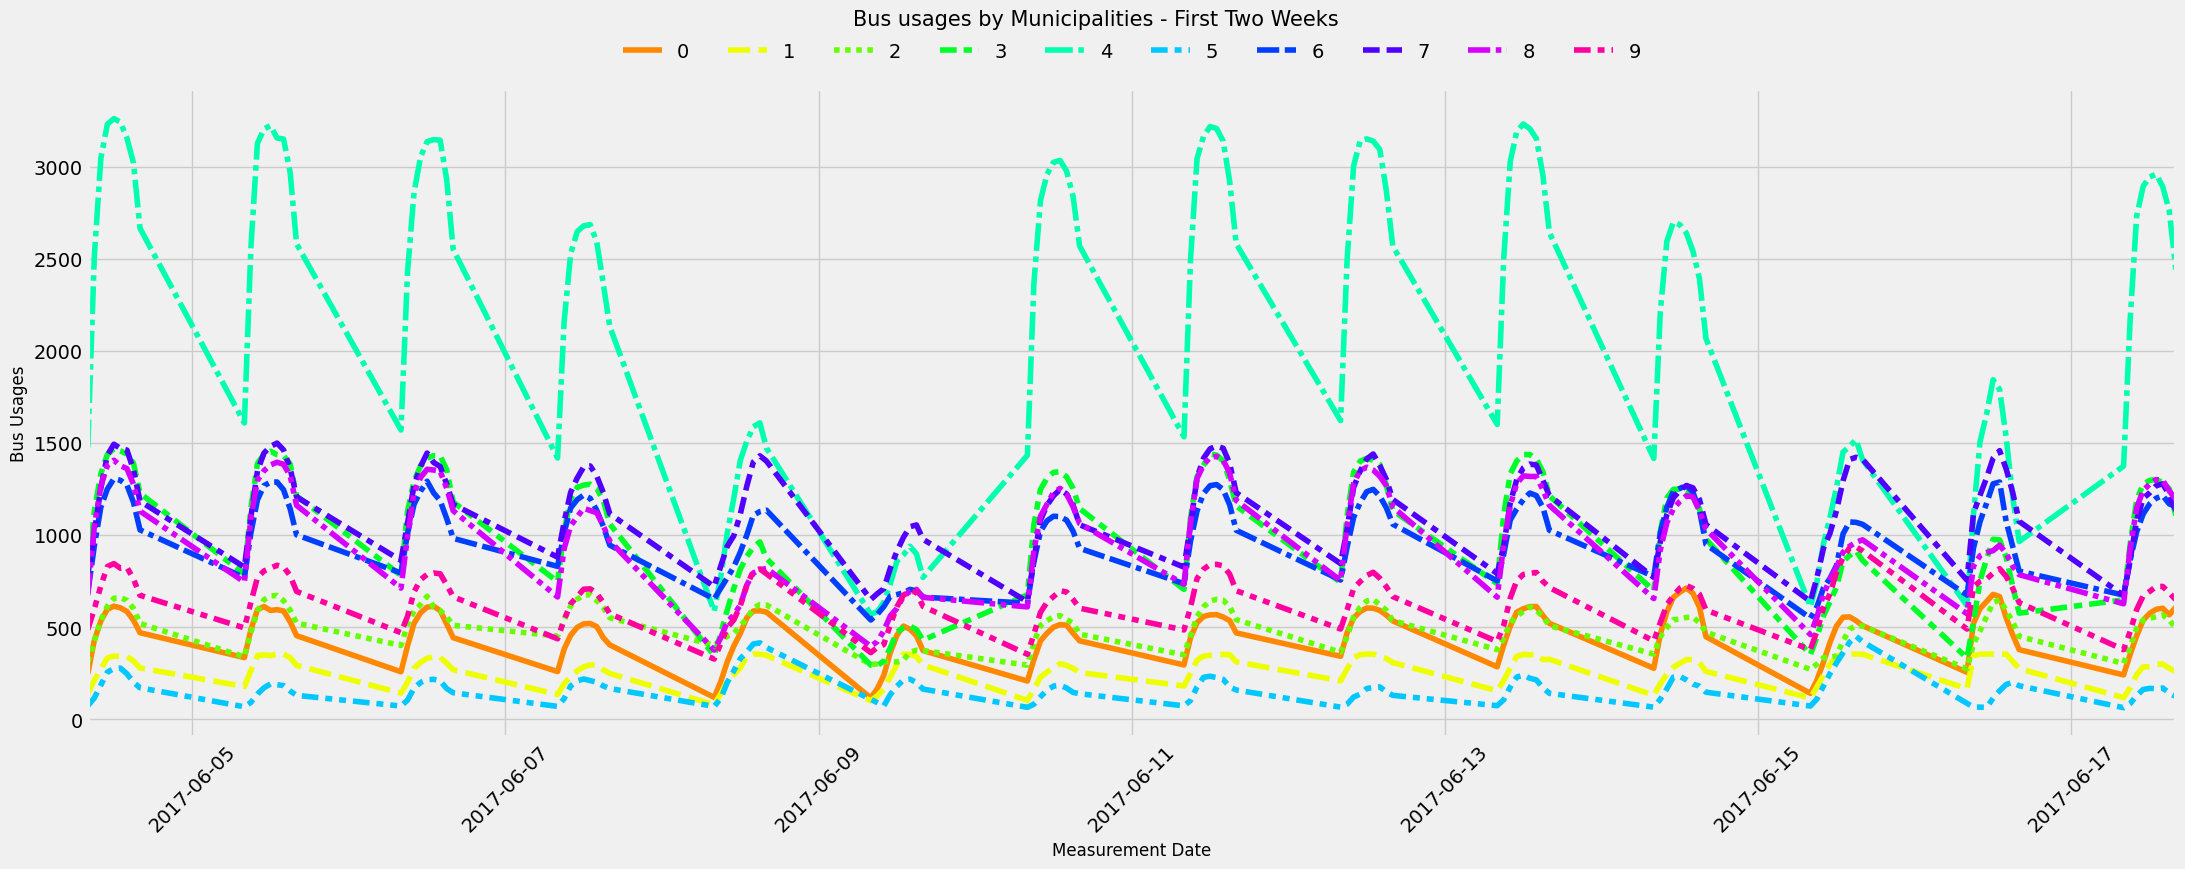

In [17]:
#got first two weeks of the data and plot bus usages
first_weeks = pivot_df.loc[pivot_df.index < '2017-06-18']

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=first_weeks, palette="hsv")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncol=len(first_weeks.columns))

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages by Municipalities - First Two Weeks", fontsize=15)
plt.xlim([first_weeks.index.min(), first_weeks.index.max()])
plt.xticks(rotation=45)

plt.show()

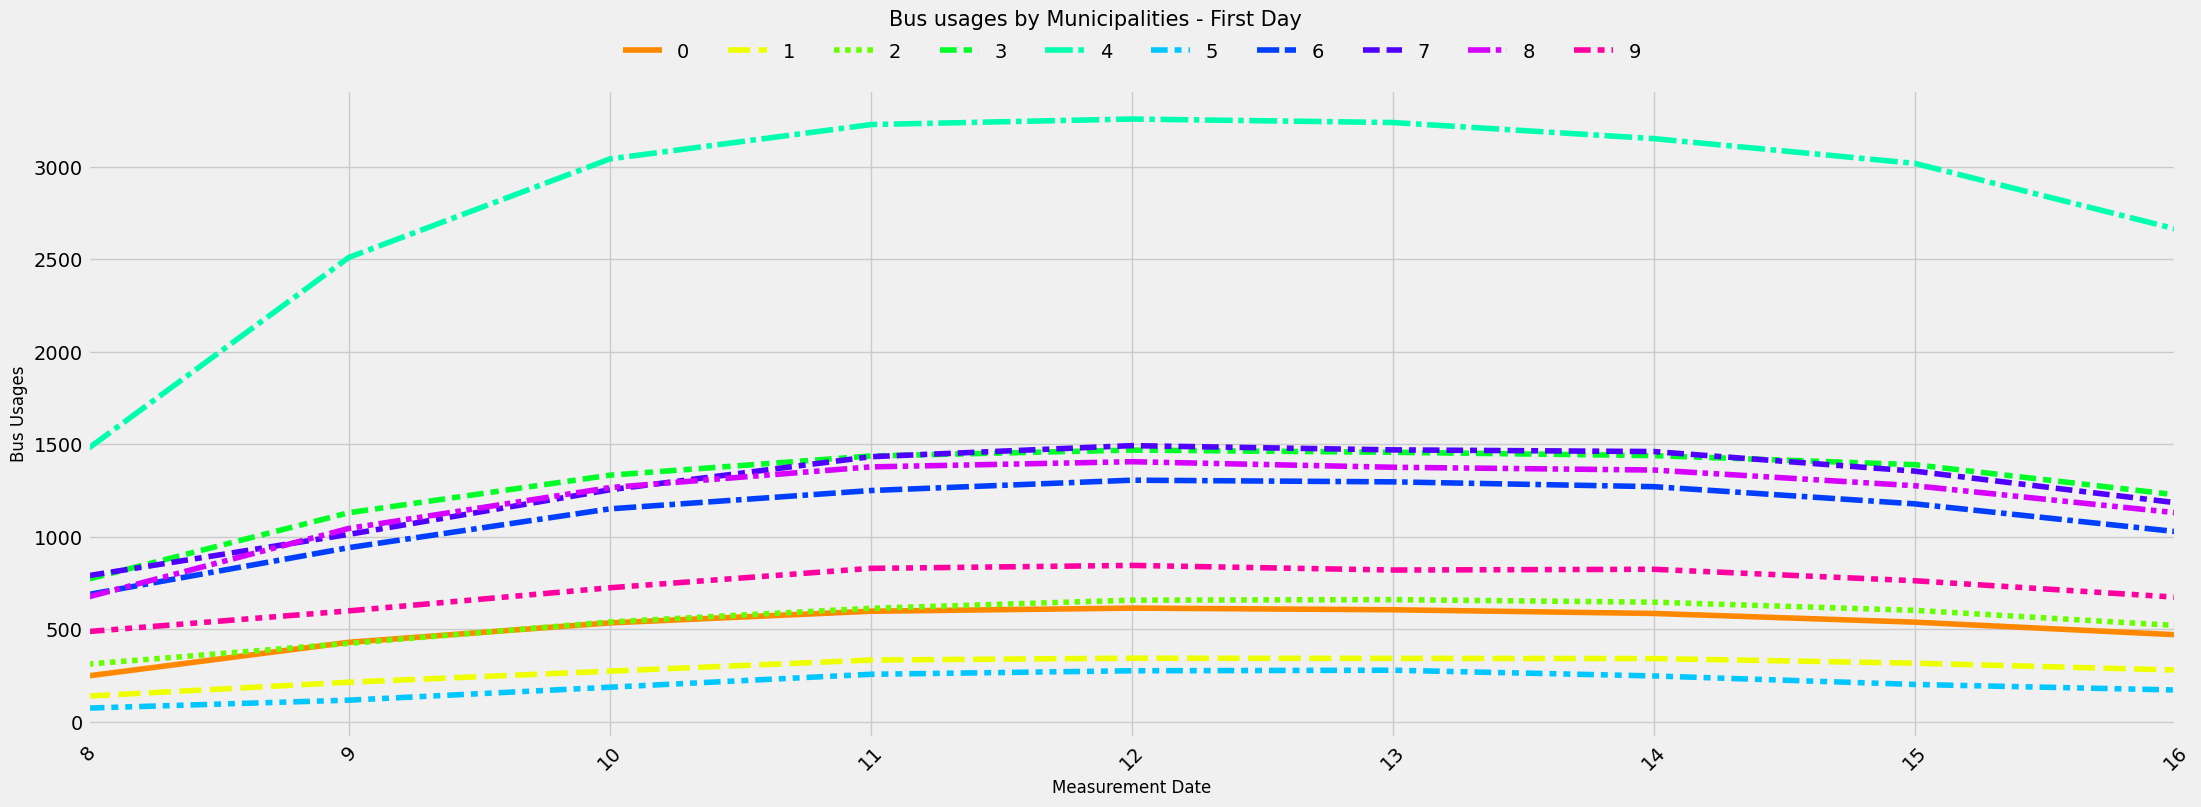

In [18]:
#got first day of the data and plot daily bus usages
first_day = pivot_df.loc[pivot_df.index < '2017-06-05']

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=first_day, palette="hsv")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncol=len(first_day.columns))

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages by Municipalities - First Day", fontsize=15)
plt.xlim([first_day.index.min(), first_day.index.max()])
plt.xticks(rotation=45)

labels = list(first_day.index.hour.unique())
ax.set_xticklabels(labels)

plt.show()

- It seems municipality 4 has the highest bus usage by far
- Also, we can see weekly pattern inside the data, so we should investigate it more after setting the baseline

# 3) Baseline Predictions

- Set a baseline performance by using municipality ids as feature and max_bus as target with time series indexes

In [19]:
#create a copy df for baseline and drop usage and total_capacity columns to avoid data leakage
baseline_df = bus_df.copy(deep=True)

In [20]:
train_data_baseline = baseline_df.loc[baseline_df.index < test_date]
test_data_baseline = baseline_df.loc[baseline_df.index >= test_date]

#get features and target
X_train_baseline = train_data_baseline.drop(columns={"usage"}, axis=1)
y_train_baseline = train_data_baseline[["usage"]]

X_test_baseline = test_data_baseline.drop(columns={"usage"}, axis=1)
y_test_baseline = test_data_baseline[["usage"]]

In [21]:
from sklearn.linear_model import Ridge

'''
-- Use Ridge regression with default parameters for a baseline performance
-- Choose evaluation metrics as root mean squared error (RMSE) and R^2 Score (Coefficient of Determination)
'''

ridge_reg = Ridge()
ridge_reg.fit(X_train_baseline, y_train_baseline)

y_pred_baseline = ridge_reg.predict(X_test_baseline)

baseline_rmse = np.sqrt(mean_squared_error(y_test_baseline, y_pred_baseline))
baseline_r2 = r2_score(y_test_baseline, y_pred_baseline)
print(
    "Baseline RMSE: %.2f" % baseline_rmse,
    "\nBaseline R^2 Score: %.4f" % baseline_r2
    )

Baseline RMSE: 434.03 
Baseline R^2 Score: 0.5229


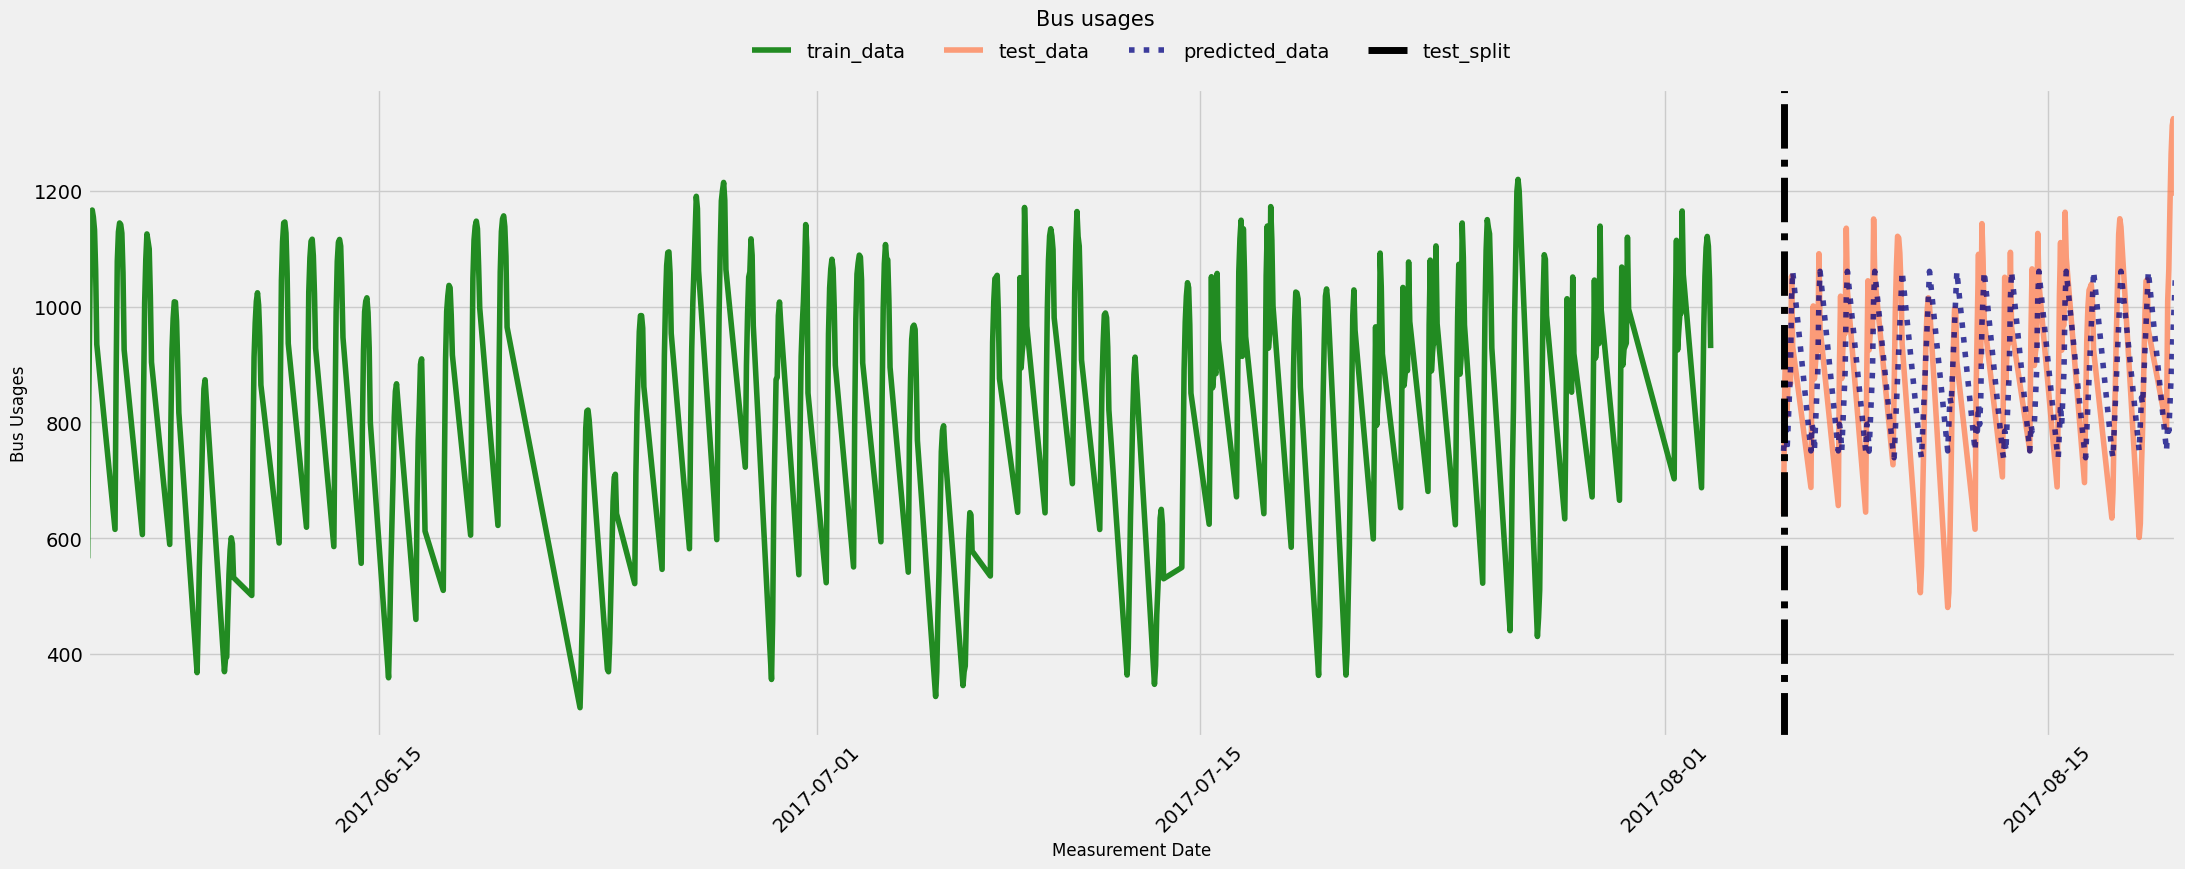

In [22]:
baseline_df = pd.DataFrame(data = y_pred_baseline, columns=y_test_baseline.columns, index=y_test_baseline.index)

#plot the time series bus usages through entire data by municipalities
train = bus_df.loc[bus_df.index < test_date]
test = bus_df.loc[bus_df.index >= test_date]

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=train, x=train.index, y="usage", errorbar=None, label="train_data", c="forestgreen")
sns.lineplot(data=test, x=test.index, y="usage", errorbar=None, label="test_data", alpha=0.75, c="coral")
sns.lineplot(data=baseline_df, x=baseline_df.index, y="usage", errorbar=None, label="predicted_data", alpha=0.75, ls="dotted", c="navy")

plt.axvline(test.index[0], lw=5, ls="dashdot", color="black", label="test_split") #add a line at test set date

plt.xlim([train.index.min(), test.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages", fontsize=15)
plt.show()

# 4) Feature Generation

- Add more features to the dataset to increase the baseline performance

In [23]:
#add a binary feature if usage that day is over the total_capacity or not
bus_df.reset_index(inplace=True)
bus_df["over_capacity"] = 0
over_cap = bus_df.query("usage > total_capacity")

bus_df.loc[over_cap.index, "over_capacity"] = 1
bus_df.set_index("timestamp", inplace=True)

bus_df

,municipality_id,usage,total_capacity,hour,over_capacity
timestamp,,,,,
2017-06-04 08:00:00,9,487,1332,8,0
2017-06-04 08:00:00,8,674,2947,8,0
2017-06-04 08:00:00,4,1476,3893,8,0
2017-06-04 08:00:00,0,247,2813,8,0
2017-06-04 08:00:00,7,789,2019,8,0
...,...,...,...,...,...
2017-08-19 16:00:00,7,1450,2019,16,0
2017-08-19 16:00:00,2,580,697,16,0
2017-08-19 16:00:00,3,1330,1930,16,0


In [24]:
#count over capacity days
bus_df.value_counts("over_capacity")

over_capacity
0    6261
1     136
dtype: int64

### Create Date Features

In [25]:
'''
-- Add date features from timestamp index
-- No year or year quarter feature since the dataset consists of from only 2 months of data
'''

bus_df["month"] = bus_df.index.month
bus_df["day"] = bus_df.index.day
bus_df["day_of_week"] = bus_df.index.day_of_week
bus_df["day_of_week_names"] = bus_df.index.day_name()
bus_df["is_weekend"] = bus_df["day_of_week_names"].apply(lambda x: 1 if x == "Saturday" or x == "Sunday" else 0)

bus_df

,municipality_id,usage,total_capacity,hour,over_capacity,month,day,day_of_week,day_of_week_names,is_weekend
timestamp,,,,,,,,,,
2017-06-04 08:00:00,9,487,1332,8,0,6,4,6,Sunday,1
2017-06-04 08:00:00,8,674,2947,8,0,6,4,6,Sunday,1
2017-06-04 08:00:00,4,1476,3893,8,0,6,4,6,Sunday,1
2017-06-04 08:00:00,0,247,2813,8,0,6,4,6,Sunday,1
2017-06-04 08:00:00,7,789,2019,8,0,6,4,6,Sunday,1
...,...,...,...,...,...,...,...,...,...,...
2017-08-19 16:00:00,7,1450,2019,16,0,8,19,5,Saturday,1
2017-08-19 16:00:00,2,580,697,16,0,8,19,5,Saturday,1
2017-08-19 16:00:00,3,1330,1930,16,0,8,19,5,Saturday,1


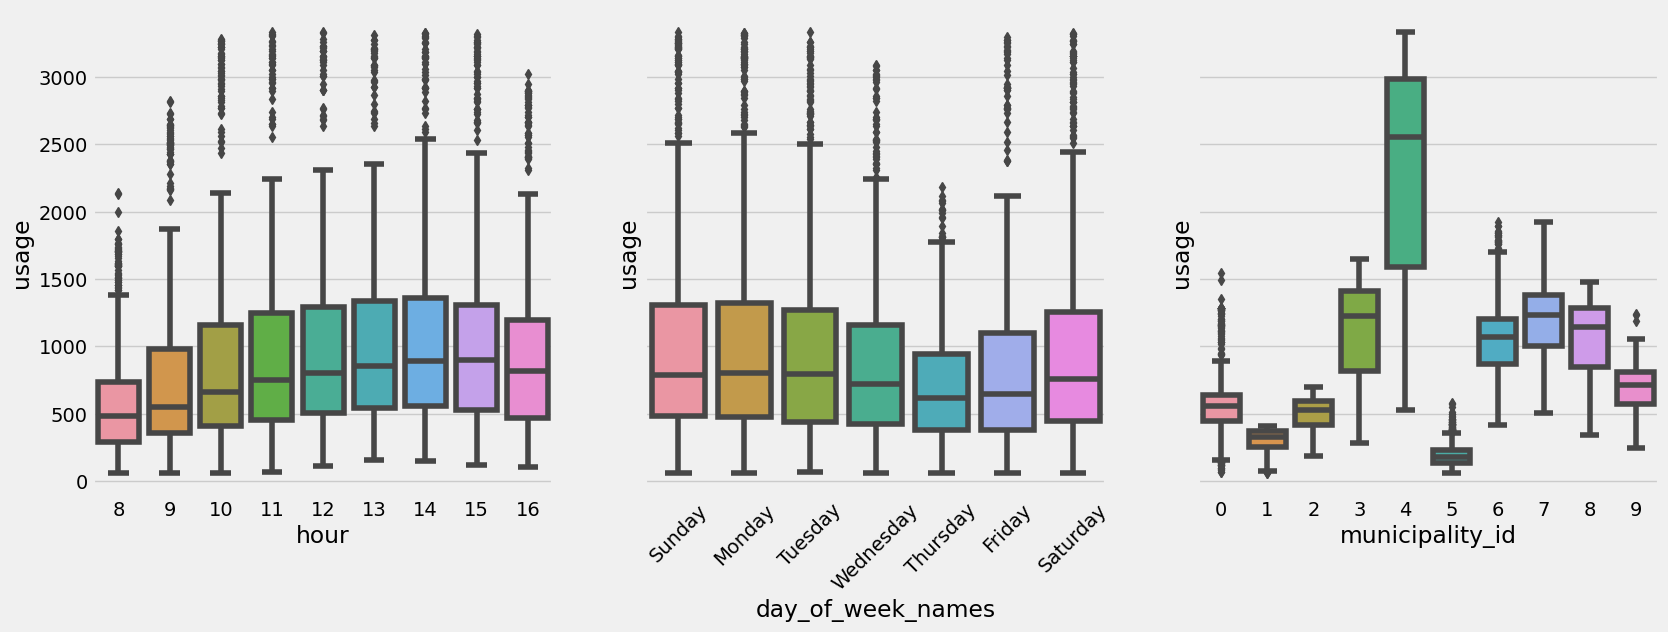

In [26]:
#plot new features to explore the dataset more

fig, ax = plt.subplots(1,3,figsize=(18,6), sharey=True)
sns.boxplot(data=bus_df, x="hour", y="usage", ax=ax[0])
sns.boxplot(data=bus_df, x="day_of_week_names", y="usage", ax=ax[1])
ax[1].tick_params(labelrotation=45)
sns.boxplot(data=bus_df, x="municipality_id", y="usage", ax=ax[2])
plt.show()

- Bus usages increase towards noon
- Middle of the weeks, bus usages are low, but increases towards weekends
- Municipality 4 has significantly higher bus usage while municipalities 1 and 5 have significantly lower bus usages

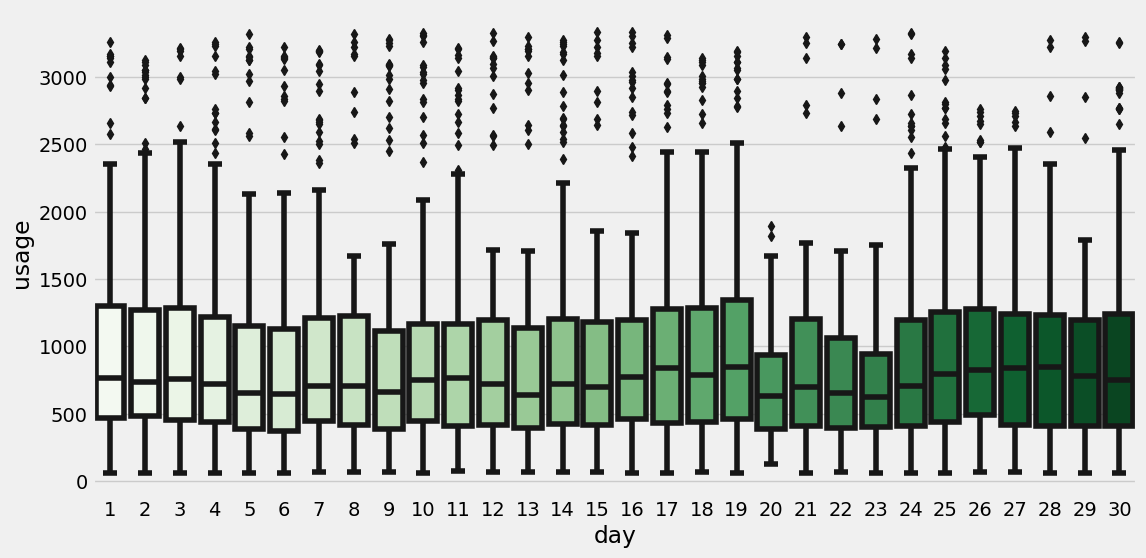

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=bus_df, x="day", y="usage", ax=ax, palette="Greens")
plt.show()

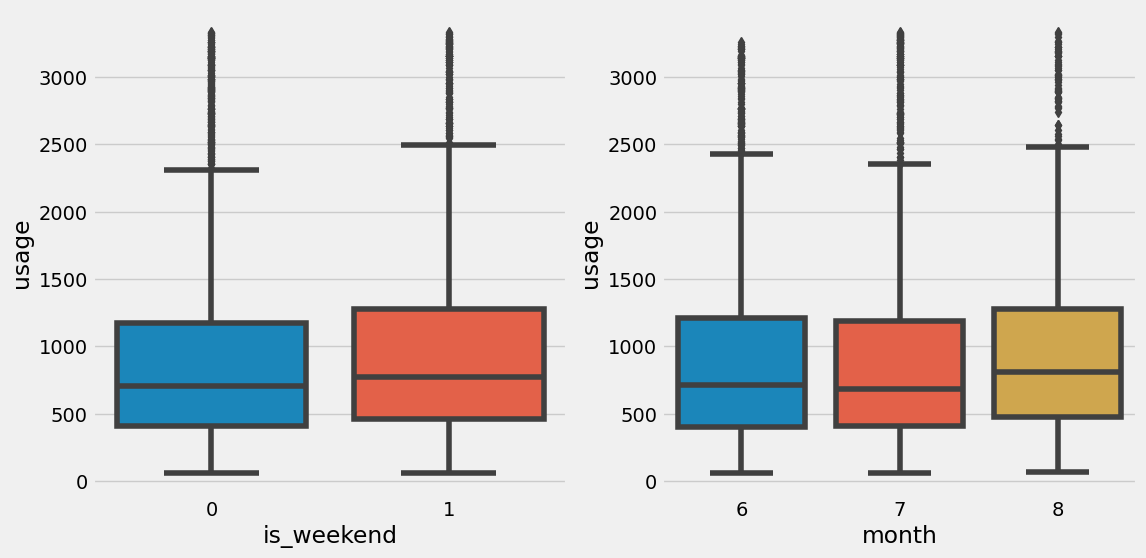

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(data=bus_df, x="is_weekend", y="usage", ax=ax[0])
sns.boxplot(data=bus_df, x="month", y="usage", ax=ax[1])
plt.show()

- Different days of month and different months, do not tell much about the bus usage patterns

### Create Lag Features

- We can create 1 and 2 weeks of lag features since we saw weekly patterns inside the data and our prediction horizon is 2 weeks

In [29]:
#add lags by filtering municipalities to not confuse timestamp indexes for each municipality
lag_dfs = []

for municipality in set(bus_df["municipality_id"]):

    temp_df = bus_df[bus_df["municipality_id"] == municipality]

    target_map = temp_df["usage"].to_dict()

    temp_df["lag_1h"] = (temp_df.index - pd.Timedelta(hours=1)).map(target_map)
    temp_df["lag_1d"] = (temp_df.index - pd.Timedelta(days=1)).map(target_map)

    lag_dfs.append(temp_df)

concatanetad_df = pd.concat(lag_dfs).reset_index()[["timestamp", "municipality_id", "lag_1h", "lag_1d"]]
concatanetad_df.set_index("timestamp", inplace=True)
concatanetad_df.sort_values(by=["timestamp", "municipality_id"], inplace=True)

bus_df.sort_values(by=["timestamp", "municipality_id"], inplace=True)
bus_df = pd.concat([bus_df, concatanetad_df[["lag_1h", "lag_1d"]]], axis=1)
bus_df

,municipality_id,usage,total_capacity,hour,over_capacity,month,day,day_of_week,day_of_week_names,is_weekend,lag_1h,lag_1d
timestamp,,,,,,,,,,,,
2017-06-04 08:00:00,0,247,2813,8,0,6,4,6,Sunday,1,NaN,NaN
2017-06-04 08:00:00,1,138,397,8,0,6,4,6,Sunday,1,NaN,NaN
2017-06-04 08:00:00,2,311,697,8,0,6,4,6,Sunday,1,NaN,NaN
2017-06-04 08:00:00,3,770,1930,8,0,6,4,6,Sunday,1,NaN,NaN
2017-06-04 08:00:00,4,1476,3893,8,0,6,4,6,Sunday,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-19 16:00:00,5,239,587,16,0,8,19,5,Saturday,1,309.0,256.0
2017-08-19 16:00:00,6,1727,3113,16,0,8,19,5,Saturday,1,1829.0,1647.0
2017-08-19 16:00:00,7,1450,2019,16,0,8,19,5,Saturday,1,1618.0,1362.0


In [30]:
bus_df.isna().sum()

municipality_id        0
usage                  0
total_capacity         0
hour                   0
over_capacity          0
month                  0
day                    0
day_of_week            0
day_of_week_names      0
is_weekend             0
lag_1h               768
lag_1d               418
dtype: int64

- Null values for lag features are coming from not having past value to look for same rows

In [31]:
#drop day_of_week_names and minute columns since they will not provide any value to the model that we will built
bus_df.drop(columns={"day_of_week_names"}, inplace=True)

# 4) Final Model and Predictions

Apply:
- Hyperparameter Tuning
- Grid Search
- Time Series Cross Validation 

to the new features to predict the test dates' bus usages. The selected algorithm for the final model is XGBoost

### Train-Test Split

In [32]:
#last 2 weeks are the test set
train_data = bus_df.loc[bus_df.index < "2017-08-05"]
test_data = bus_df.loc[bus_df.index >= "2017-08-05"]

X_train = train_data.drop(columns="usage", axis=1)
y_train = train_data[["usage"]]

X_test = test_data.drop(columns="usage", axis=1)
y_test = test_data[["usage"]]

### Time-Series Cross-Validation

In [33]:
scores_mse, scores_r2 = {}, {}

n_fold = 5

tss = TimeSeriesSplit(n_splits = n_fold)

xgb = xgboost.XGBRegressor()

for (train_index, val_index), fold in zip(tss.split(X_train), range(1,n_fold+1)):
    X_train_fold, X_val_fold = X_train.iloc[train_index, :], X_train.iloc[val_index,:]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    xgb.fit(X_train_fold, y_train_fold)
    y_pred = xgb.predict(X_val_fold)

    print(
        "---Fold: ", fold, "---", 
        "\nRMSE: %.4f" % np.sqrt(mean_squared_error(y_val_fold, y_pred)),
        "\nR2_Score: %.4f" % r2_score(y_val_fold, y_pred), "\n" ,sep=""
        )

    scores_mse[fold] = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    scores_r2[fold] = r2_score(y_val_fold, y_pred)

print(
    "Average RMSE: %.4f" % np.mean(list(scores_mse.values())),
    "\nAverage R2_Score: %.4f" % np.mean(list(scores_r2.values()))
)

---Fold: 1---
RMSE: 90.4327
R2_Score: 0.9770

---Fold: 2---
RMSE: 101.6308
R2_Score: 0.9771

---Fold: 3---
RMSE: 105.7901
R2_Score: 0.9729

---Fold: 4---
RMSE: 130.8116
R2_Score: 0.9588

---Fold: 5---
RMSE: 101.2578
R2_Score: 0.9752

Average RMSE: 105.9846 
Average R2_Score: 0.9722


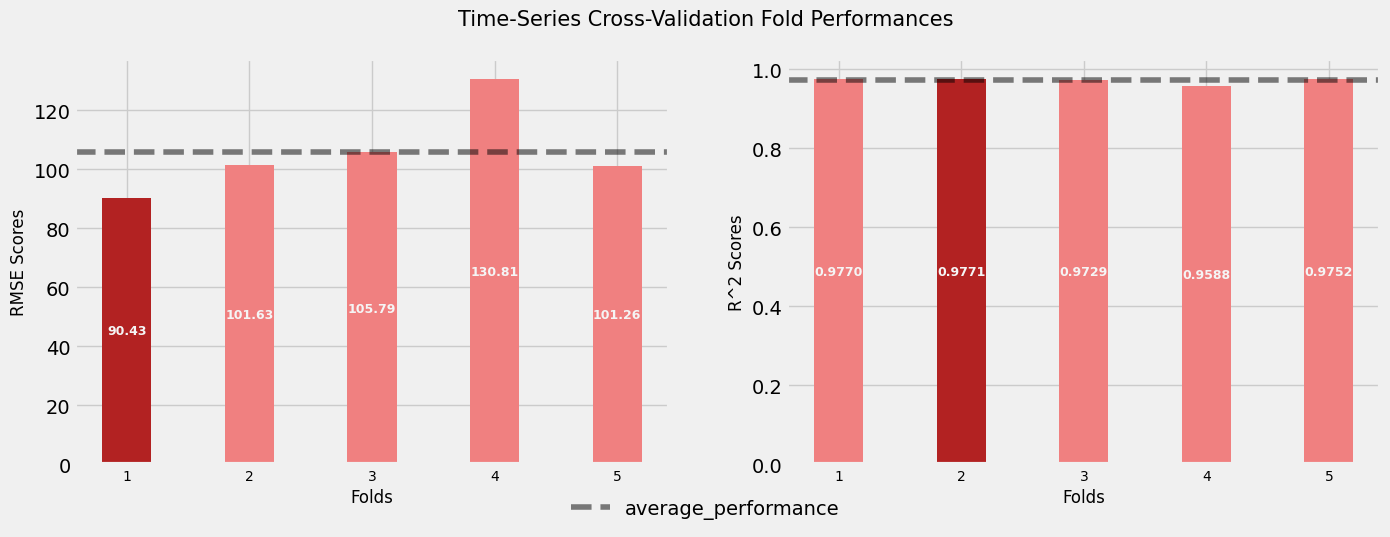

In [34]:
#plot cv results
fig, ax = plt.subplots(1,2,figsize=(15,5))

ind = np.arange(len(scores_mse)) + 0.3
width = 0.4

for i,score_dict in enumerate([scores_mse, scores_r2]): 
    scores = list(score_dict.values())

    bars = ax[i].bar(ind, scores, width, color="lightcoral")
    ax[i].bar_label(bars, fmt=('%.2f' if i==0 else '%.4f'), weight='bold', label_type='center', color='whitesmoke', fontsize=9, label="fold_performance")
    ax[i].patches[scores.index(min(scores)) if i==0 else scores.index(max(scores))].set_facecolor('firebrick') # Highlight the best resulted fold
    ax[i].axhline(np.mean(scores), ls="--", alpha=0.5, color="black", label=("average_performance" if i==0 else "_nolegend_")) # Draw a dashed line of the mean performance
    ax[i].set_xticks(ind, labels = score_dict.keys(), fontsize=10)
    ax[i].set_xlabel("Folds", fontsize=12)
    ax[i].set_ylabel("RMSE Scores" if i==0 else "R^2 Scores", fontsize=12)

fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.075), frameon=False)

fig.suptitle("Time-Series Cross-Validation Fold Performances", fontsize=15)
plt.show()

Cross-validated results look way better than the baseline with default parameters of XGBoost

### Hyperparameter Tuning

In [35]:
#XGBoost - Hyperparameter tuning to find the best parameters
params = { 
        'max_depth': [3,6,10,50],
        'learning_rate': [0.005, 0.01, 0.05, 0.1],
        'n_estimators': [100, 250, 500, 1000],
        'reg_lambda': [0.0, 0.25, 0.5, 1, 1.25, 1.5, 2.0]
        }

xgb = xgboost.XGBRegressor()
grid = GridSearchCV(
        estimator=xgb,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1
        )

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000, 'reg_lambda': 0.5}


### Final Predictions Performance with the Test Set

In [36]:
#Test set performance on tuned parameters
xgb = xgboost.XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000, reg_lambda=0.5)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

final_rmse =  np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)
print(
    "Final RMSE: %.4f" % final_rmse,
    "\nFinal R^2 Score: %.4f" % final_r2
    )

Final RMSE: 89.1692 
Final R^2 Score: 0.9799


### Feature Importances

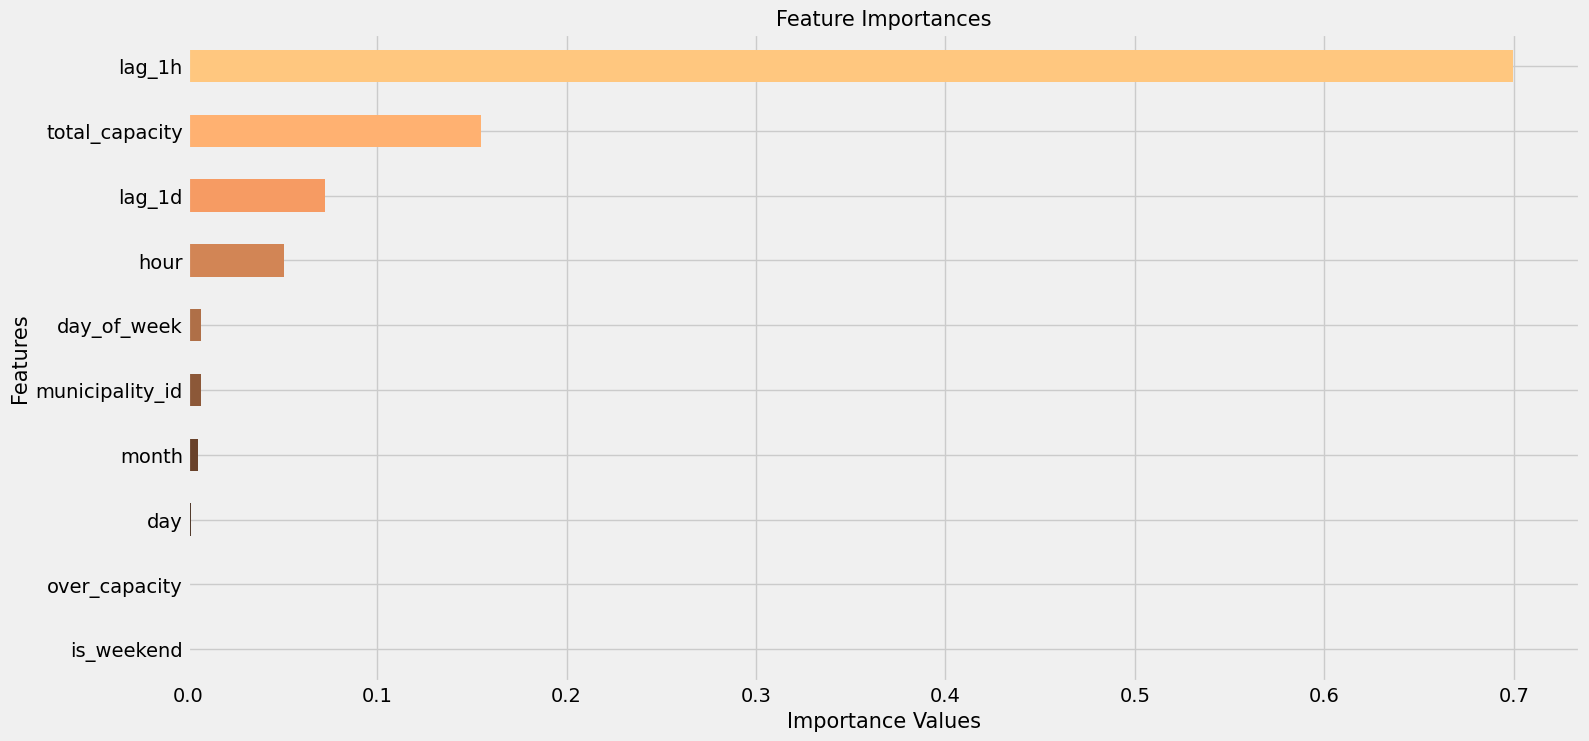

In [37]:
imp = xgb.feature_importances_

importances = pd.DataFrame({"feature": X_train.columns, "importance": imp})
importances = importances.sort_values(by="importance")

colors = mcp.gen_color(cmap='copper', n=len(importances))

ax = importances.plot(kind='barh', x='feature', y='importance', figsize=(16,8), color=colors, legend=False)
#ax.axvline(0.05, ls="--", color="firebrick")
plt.xlabel("Importance Values", fontsize=15)
plt.ylabel("Features", fontsize=15)
plt.title("Feature Importances", fontsize=15)
plt.show()

Lag feature with 1-hour sliding window has the biggest importance over all features

### Predictions

In [38]:
#creating predictions dataframe
pred_df = pd.DataFrame({
    "municipality_id": test_data["municipality_id"].values,
    "usage": test_data["usage"].values,
    "predictions": y_pred
    }, index=y_test.index)

pred_df["error"] = np.abs(pred_df["usage"] - pred_df["predictions"])
pred_df.head()

,municipality_id,usage,predictions,error
timestamp,,,,
2017-08-05 08:00:00,0,252,341.199768,89.199768
2017-08-05 08:00:00,1,158,194.290329,36.290329
2017-08-05 08:00:00,2,327,449.875763,122.875763
2017-08-05 08:00:00,3,781,677.543823,103.456177
2017-08-05 08:00:00,4,2132,1710.465454,421.534546


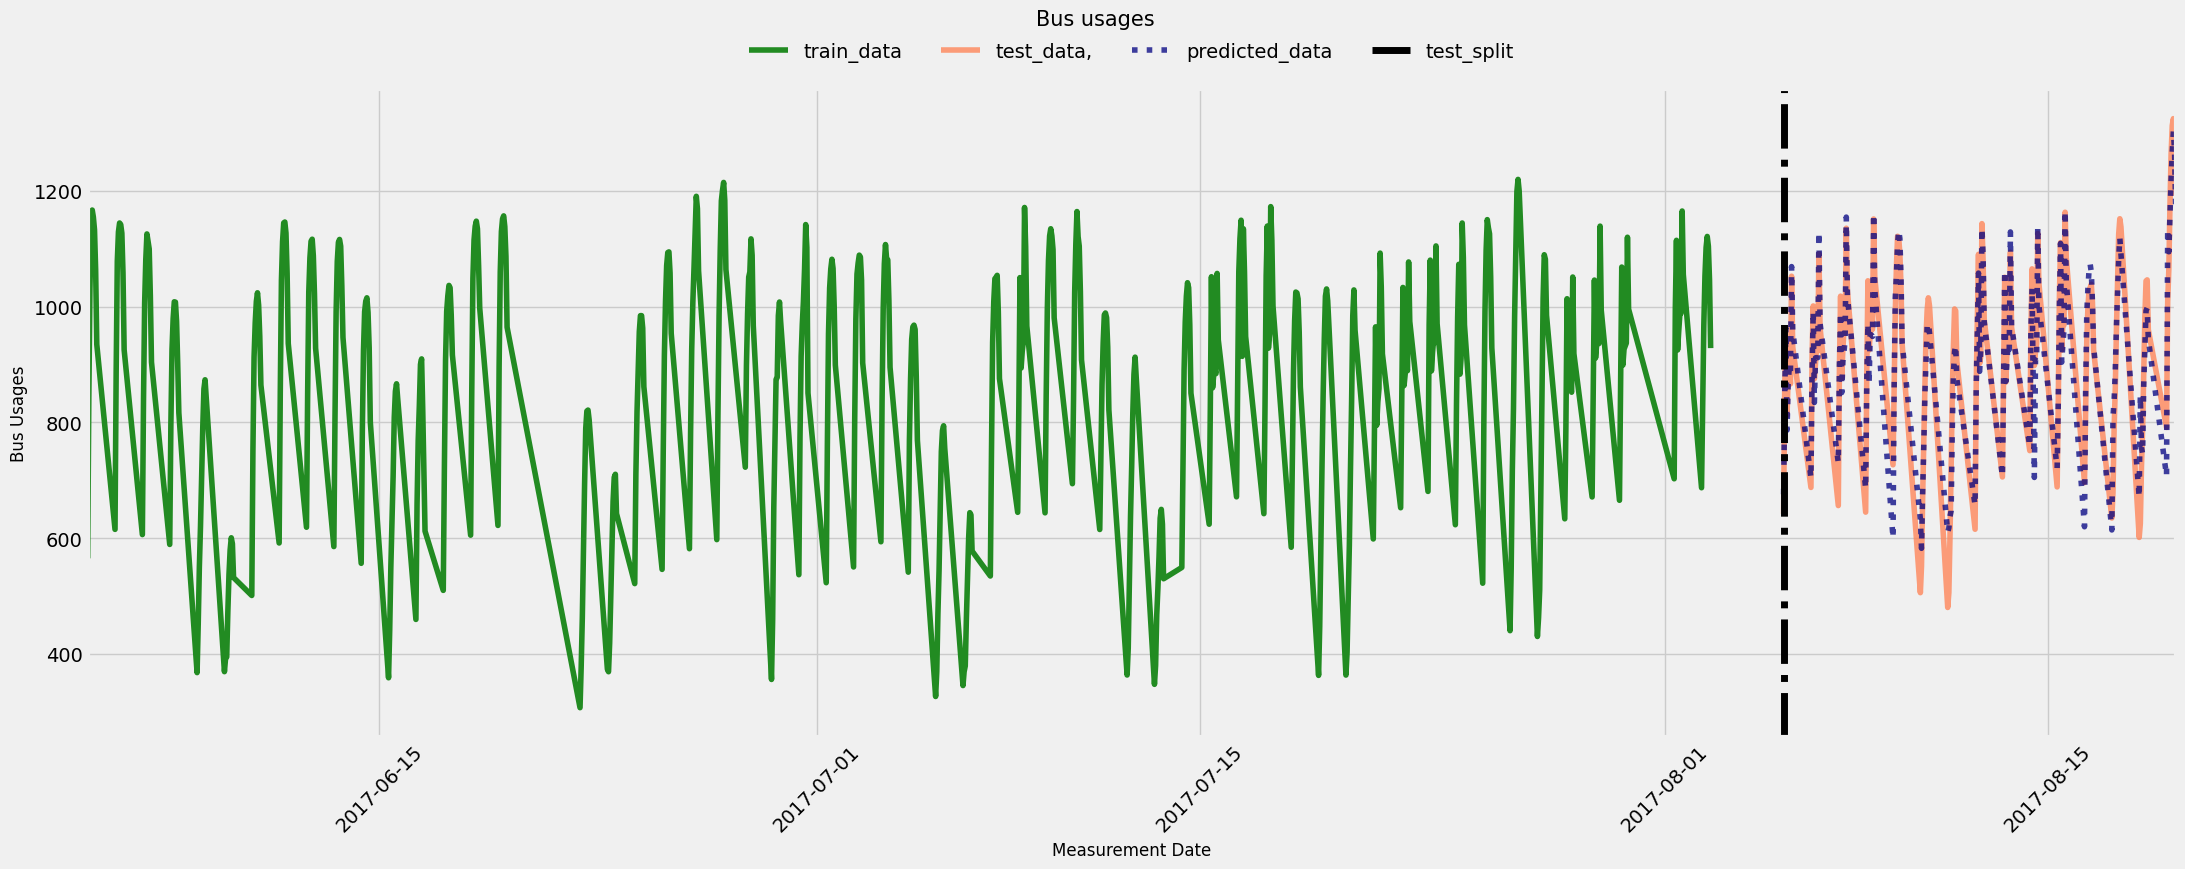

In [39]:
#plot actual and the predicted bus usages
train = bus_df.loc[bus_df.index < test_date]
test = bus_df.loc[bus_df.index >= test_date]

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=train, x=train.index, y="usage", errorbar=None, label="train_data", c="forestgreen")
sns.lineplot(data=pred_df, x=pred_df.index, y="usage", errorbar=None, label="test_data,", alpha=0.75, c="coral")
sns.lineplot(data=pred_df, x=pred_df.index, y="predictions", errorbar=None, label="predicted_data", alpha=0.75, ls="dotted", c="navy")

plt.axvline(test.index[0], lw=5, ls="dashdot", color="black", label="test_split") #add a line at test set date

plt.xlim([train.index.min(), test.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages", fontsize=15)
plt.show()

The final model performance looks like having more overlapped predictions with the test data than the baseline

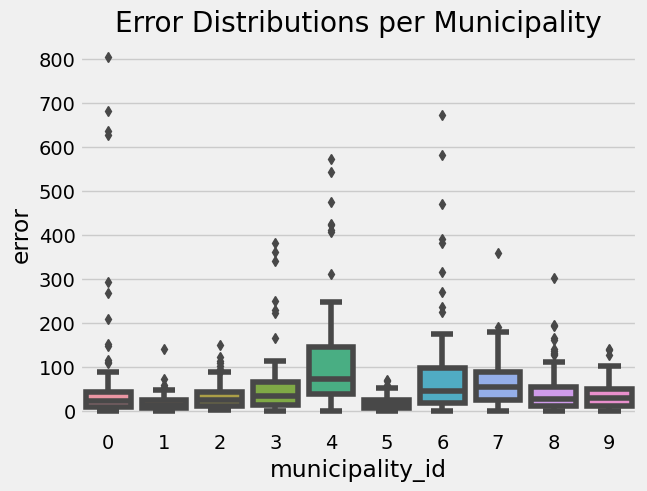

In [40]:
sns.boxplot(data=pred_df, x="municipality_id", y="error")
plt.title("Error Distributions per Municipality")
plt.show()